# Multi-period OPF example

In [1]:
import os
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypower.api as pp
from datetime import datetime, timedelta
import nygrid.opf as opf
from nygrid.run_nygrid import NYGrid


In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('GIS data directory not found.')

print('GRID data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

GRID data directory: /home/by276/models/NYgrid-python/data/grid
Figure directory: /home/by276/models/NYgrid-python/figures


## Read grid data

In [3]:
start_date = datetime(2018, 8, 5, 0, 0, 0)
end_date = datetime(2018, 8, 16, 0, 0, 0)

# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'


# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'

# Read generator capacity limit profile
genmax_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmax_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmax_profile.index.freq = 'H'

genmin_profile = pd.read_csv(os.path.join(grid_data_dir, f'genmin_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genmin_profile.index.freq = 'H'

# Read generator ramp rate profile
genramp30_profile = pd.read_csv(os.path.join(grid_data_dir, f'genramp30_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
genramp30_profile.index.freq = 'H'

# Read generator cost profile (linear)
gencost0_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost0_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost0_profile.index.freq = 'H'

gencost1_profile = pd.read_csv(os.path.join(grid_data_dir, f'gencost1_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gencost1_profile.index.freq = 'H'


## Multi-period OPF

In [4]:
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
num_day = len(timestamp_list) - 1


In [16]:
# Only run for one day
d = 4
start_datetime = timestamp_list[d]
end_datetime = timestamp_list[d+1]
print(f'Start time: {start_datetime}')
print(f'End time: {end_datetime}')
load = load_profile.loc[start_datetime:end_datetime].to_numpy()

Start time: 2018-08-09 00:00:00
End time: 2018-08-10 00:00:00


In [17]:
# Read MATPOWER case file
ppc_filename = os.path.join(data_dir, 'ny_grid.mat')

nygrid_sim = NYGrid(ppc_filename, 
                    start_datetime=start_datetime.strftime('%Y-%m-%d'), 
                    end_datetime=end_datetime.strftime('%Y-%m-%d'), 
                    verbose=True)

# Read grid data
nygrid_sim.get_load_data(load_profile)
nygrid_sim.get_gen_data(gen_profile)
nygrid_sim.get_genmax_data(genmax_profile)
nygrid_sim.get_genmin_data(genmin_profile)
nygrid_sim.get_genramp_data(genramp30_profile)
nygrid_sim.get_gencost_data(gencost0_profile, gencost1_profile)

# Process ppc
nygrid_sim.process_ppc()

# Check input
nygrid_sim.check_input_dim()

Initializing NYGrid run...
NYGrid run starting on: 2018-08-09 00:00:00
NYGrid run ending on: 2018-08-10 00:00:00


In [18]:
# Initialize single period OPF
model_multi_opf = nygrid_sim.create_multi_opf()

[    0.00] Starting timer ...
[+   1.11] Created constraints for time step 0 ...
[+   1.08] Created constraints for time step 1 ...
[+   1.08] Created constraints for time step 2 ...
[+   1.07] Created constraints for time step 3 ...
[+   1.08] Created constraints for time step 4 ...
[+   1.17] Created constraints for time step 5 ...
[+   1.08] Created constraints for time step 6 ...
[+   1.08] Created constraints for time step 7 ...
[+   1.11] Created constraints for time step 8 ...
[+   1.10] Created constraints for time step 9 ...
[+   1.08] Created constraints for time step 10 ...
[+   1.08] Created constraints for time step 11 ...
[+   1.08] Created constraints for time step 12 ...
[+   1.08] Created constraints for time step 13 ...
[+   1.08] Created constraints for time step 14 ...
[+   1.08] Created constraints for time step 15 ...
[+   1.08] Created constraints for time step 16 ...
[+   1.08] Created constraints for time step 17 ...
[+   1.08] Created constraints for time step

In [19]:
solver = SolverFactory('glpk')
results_multi_opf = solver.solve(model_multi_opf, tee=True)

if nygrid_sim.check_status(results_multi_opf):
     print('%.2f' % model_multi_opf.obj())

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpskreb63h.glpk.raw --wglp /tmp/tmpsj5vviqk.glpk.glp --cpxlp
 /tmp/tmpv9w6t891.pyomo.lp
Reading problem data from '/tmp/tmpv9w6t891.pyomo.lp'...
36468 rows, 10751 columns, 67035 non-zeros
193973 lines were read
Writing problem data to '/tmp/tmpsj5vviqk.glpk.glp'...
165801 lines were written
GLPK Simplex Optimizer 5.0
36468 rows, 10751 columns, 67035 non-zeros
Preprocessing...
6523 rows, 8425 columns, 23621 non-zeros
Scaling...
 A: min|aij| =  1.061e-01  max|aij| =  5.058e+02  ratio =  4.766e+03
GM: min|aij| =  4.212e-02  max|aij| =  2.374e+01  ratio =  5.636e+02
EQ: min|aij| =  1.774e-03  max|aij| =  1.000e+00  ratio =  5.636e+02
Constructing initial basis...
Size of triangular part is 6473
      0: obj =   8.043981526e+07 inf =   3.136e+03 (1239)
   7477: obj =   7.628826322e+07 inf =   4.263e-14 (0) 39
* 12968: obj =   5.501022658e+07 inf =   3.109e-14 (0) 31
OPTIMAL LP SOLUTION FOUND
Time used:

## Process the results

In [20]:
results = nygrid_sim.get_results_multi_opf(model_multi_opf)

In [21]:
results.keys()

dict_keys(['PG', 'VA', 'PF', 'IF', 'LMP'])

In [22]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,maxRamp10,maxRamp30,maxRamp60,HeatRateLM_R2,HeatRateQM_R2,BusName,NCOST,cost_1,cost_0
0,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,0.733333,7.333333,22.00,44.0,0.862443,0.891407,62,1,22.682017,-40.234372
1,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.591500,-74.202700,349.0,96.0,2.850000,28.500000,85.50,171.0,0.995837,0.995860,82,1,25.306225,736.980064
2,Arthur Kill ST 3,23513,J,Steam Turbine,Natural Gas,40.591500,-74.202700,539.0,1.0,3.108333,31.083333,93.25,186.5,0.986235,0.991460,82,1,25.957282,993.894899
3,Astoria 2,24149,J,Steam Turbine,Natural Gas,40.786900,-73.912200,153.0,1.0,0.808333,8.083333,24.25,48.5,0.987563,0.988910,82,1,31.302863,430.832898
4,Astoria 3,23516,J,Steam Turbine,Fuel Oil 2,40.786900,-73.912200,756.0,40.0,6.033333,60.333333,181.00,362.0,0.996075,0.996269,82,1,66.084194,3680.943877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Shoreham 1,23715,K,Combustion Turbine,Fuel Oil 2,40.957200,-72.866400,52.9,0.0,0.881667,8.816667,26.45,52.9,0.000000,0.000000,80,1,195.331050,0.000000
223,Shoreham 2,23716,K,Jet Engine,Fuel Oil 2,40.957200,-72.866400,18.6,0.0,0.310000,3.100000,9.30,18.6,0.000000,0.000000,80,1,195.331050,0.000000
224,South Cairo,23612,G,Combustion Turbine,Kerosene,42.291275,-73.986452,21.6,0.0,0.360000,3.600000,10.80,21.6,0.000000,0.000000,39,1,195.331050,0.000000
225,Southold 1,23719,K,Combustion Turbine,Fuel Oil 2,41.105900,-72.376100,14.0,0.0,0.233333,2.333333,7.00,14.0,0.000000,0.000000,80,1,195.331050,0.000000


In [23]:
gen_info.iloc[7, :]

NYISOName          Astoria CC 2
PTID                     323569
Zone                          J
UnitType         Combined Cycle
FuelType            Natural Gas
Latitude                40.7881
Longitude              -73.9056
maxPower                  320.0
minPower                   99.0
maxRampAgc             2.691667
maxRamp10             26.916667
maxRamp30                 80.75
maxRamp60                 161.5
HeatRateLM_R2          0.885957
HeatRateQM_R2          0.887447
BusName                      82
NCOST                         1
cost_1                14.944637
cost_0              1090.960576
Name: 7, dtype: object

In [24]:
num_thermal = gen_info.shape[0]
results_pg = results['PG']
thermal_pg = results_pg.iloc[:, :num_thermal]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
thermal_pg = thermal_pg.rename(columns=gen_rename)
thermal_pg

,Allegany,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,Astoria 3,Astoria 5,Astoria CC 1,Astoria CC 2,Astoria East Energy - CC1,Astoria East Energy - CC2,...,Northport GT,Ravenswood 01,Ravenswood 10,Ravenswood 11,S Hampton 1,Shoreham 1,Shoreham 2,South Cairo,Southold 1,St. Elizabeth Medical Center
2018-08-09 00:00:00,0.0,0.0,0.0,66.0,1.000000e-01,11.1,0.0,349.0,539.0,1.0,...,0.6,37.5,46.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 01:00:00,0.0,0.0,0.0,11.0,7.105427e-13,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,46.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 02:00:00,0.0,0.0,0.0,11.0,-3.552714e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,46.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 03:00:00,0.0,0.0,0.0,11.0,-6.394885e-12,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 04:00:00,0.0,0.0,0.0,11.0,5.613288e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 05:00:00,0.0,0.0,0.0,11.0,1.350031e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,30.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 06:00:00,0.0,0.0,0.0,11.0,5.329071e-11,0.0,0.0,96.0,1.0,1.0,...,0.0,15.0,40.205671,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 07:00:00,0.0,0.0,0.0,66.0,-3.979039e-11,11.1,0.0,349.0,539.0,1.0,...,0.0,15.0,46.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 08:00:00,0.0,0.0,0.0,66.0,1.000000e-01,11.1,0.0,349.0,539.0,1.0,...,0.6,37.5,46.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-08-09 09:00:00,0.0,0.0,0.0,66.0,1.000000e-01,11.1,0.0,349.0,539.0,1.0,...,0.6,43.0,46.000000,102.0,18.5,15.0,9.0,7.8,4.0,3.0


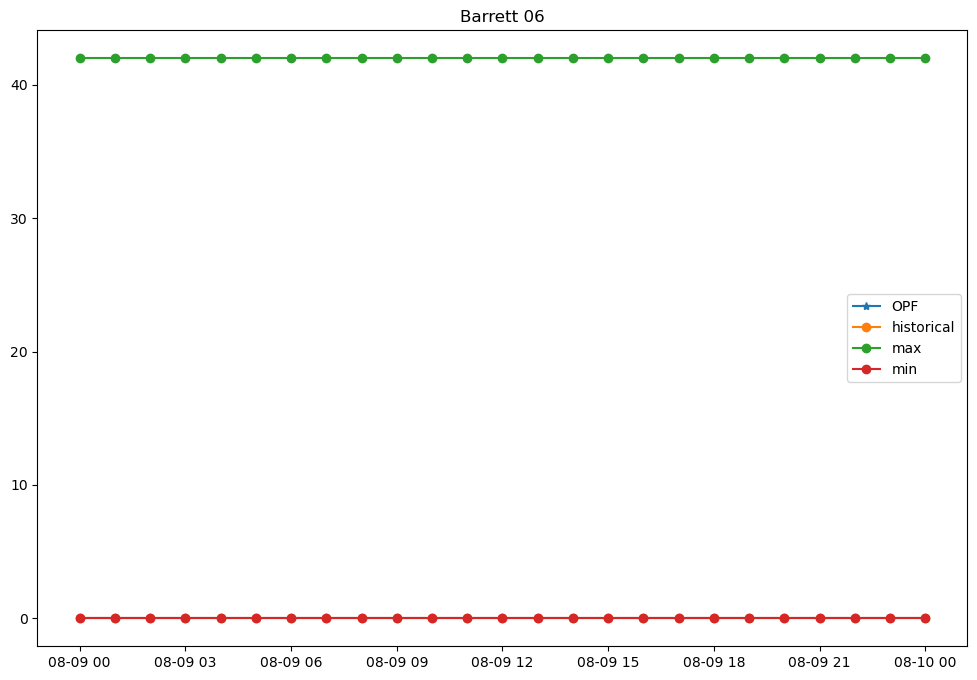

In [25]:
ii = 30
fig, ax = plt.subplots(figsize=(12, 8))
# thermal_pg['Astoria CC 2'].plot(ax=ax, marker='*')
ax.plot(thermal_pg.index, thermal_pg.iloc[:, ii], marker='*', label='OPF')
ax.plot(thermal_pg.index, nygrid_sim.gen_profile[:, ii], marker='o', label='historical')
ax.plot(thermal_pg.index, nygrid_sim.genmax_profile[:, ii], marker='o', label='max')
ax.plot(thermal_pg.index, nygrid_sim.genmin_profile[:, ii], marker='o', label='min')
ax.legend()
ax.set_title(gen_info.NYISOName[ii])
plt.show()

In [26]:
# # Save thermal generation to a csv file
# resultsdir = '../results'
# if not os.path.isdir(resultsdir):
#     os.makedirs(resultsdir)
# basename = f'thermal_{start_time.strftime("%Y%m%d%H%M")}_{end_time.strftime("%Y%m%d%H%M")}.csv'
# filename = os.path.join(resultsdir, basename)
# thermal_pg.to_csv(filename)
# print(f'Saved thermal generation results in {filename}')